<a href="https://colab.research.google.com/github/y-kallel/keras-retinanet/blob/master/Package_Detection_with_Keras_Retinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection in Google Colab with Fizyr Retinanet

Jupyter notebook providing steps to train a Keras/Tensorflow model for object detection with custom dataset.

It runs in Google Colab using [Fizyr implementation](https://github.com/fizyr/keras-retinanet) of RetinaNet in Keras.

Requirements are only dataset images and annotations file made in [LabelImg](https://github.com/tzutalin/labelImg).

Colab Runtime type: Python3, GPU enabled.

# Environment Setup
Download and install in Colab required packages and import libraries. Current git repo has custom package dataset, alter the current dataset by adding more images and their corresponding annotation xml files creted using labelImg. 

In [ ]:
!git clone https://github.com/y-kallel/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 5827 (delta 17), reused 1 (delta 0), pack-reused 5800
Receiving objects: 100% (5827/5827), 16.49 MiB | 25.43 MiB/s, done.
Resolving deltas: 100% (3897/3897), done.


In [ ]:
%cd /content/keras-retinanet/
!git checkout master
!git pull origin master
!pip install .

/content/keras-retinanet
Branch 'tf-keras' set up to track remote branch 'tf-keras' from 'origin'.
Switched to a new branch 'tf-keras'
From https://github.com/y-kallel/keras-retinanet
 * branch            tf-keras   -> FETCH_HEAD
Already up to date.
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=168402 sha256=4aea316e726d1e300b0d9995a5c9f9fc0a2094ba24bd973e4c6f645196dc7095
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=c566f904016a90dc7027c2af815bc30c066418424f8b88737d3e1e3da2441bdc
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [ ]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [ ]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

# Making Dataset

Download from Drive training dataset, and convert it to Fizyr annotations format.

Before upload in Google Drive a zip file containing annotations and images for training dataset, with following format (check my zip sample):

```
objdet_reduced_dataset.zip
|- img1.jpg
|- img1.xml
|- img2.jpg
|- img2.xml
...
```

Then change accordingly DATASET_DRIVEID.

In [ ]:
DATASET_DIR = 'dataset'
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install .  -q

In [ ]:
#Do this only once
!pip install --upgrade git+https://github.com/broadinstitute/keras-resnet -q

ERROR: keras-retinanet 0.5.1 has requirement keras-resnet==0.1.0, but you'll have keras-resnet 0.2.0 which is incompatible.


In [ ]:
annotations = []
classes = set([])

for xml_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".xml")]:
  tree = ET.parse(os.path.join(DATASET_DIR, xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join(DATASET_DIR, elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          for subsubelem in subelem:
            coords.append(subsubelem.text)
      item = [file_name] + coords + [obj_name]
      annotations.append(item)
      classes.add(obj_name)

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

# Training Model

Download pretrained model and run training.

In the next cell choose one option:

1.   download Fizyr Resnet50 pretrained model
2.   download your custom pretrained model, to continue previous training epochs

In the last cell optionally export trained model to Google Drive.


In [ ]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

#### OPTION 2: DOWNLOAD CUSTOM PRETRAINED MODEL FROM GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####
#drive.mount('/content/gdrive')
#DRIVE_MODEL = '/content/gdrive/My Drive/Colab Notebooks/objdet_tensorflow_colab/resnet50_csv_10.h5'
#shutil.copy(DRIVE_MODEL, PRETRAINED_MODEL)


print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [ ]:
import tensorflow as tf
print(tf.__version__)

!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

2.2.0
2020-07-15 20:52:49.600677: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Instructions for updating:
non-resource variables are not supported in the long term
Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-07-15 20:52:54.504547: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-15 20:52:54.518080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-15 20:52:54.518654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB 

In [ ]:
#### OPTIONAL: EXPORT TRAINED MODEL TO DRIVE ####
from google.colab import drive

drive.mount('/content/gdrive')
COLAB_MODEL = '/resnet50_csv_10.h5'
DRIVE_DIR = '/content/gdrive/My Drive/Colab Notebooks/retinanet_pckg.pt'
shutil.copy(COLAB_MODEL, DRIVE_DIR)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks/retinanet_pckg.pt'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install toco
!pip install --upgrade keras

  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
!toco --output_file=keras.tflite --keras_model_file='/content/resnet50_csv_10.h5' --input_arrays input_1 --input_shape 1,300,300,3 --allow_custom_ops

Traceback (most recent call last):
  File "/usr/local/bin/toco", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/lite/python/tflite_convert.py", line 594, in main
    app.run(main=run_main, argv=sys.argv[:1])
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/usr/local/lib/python2.7/dist-packages/absl/app.py", line 300, in run
    _run_main(main, args)
  File "/usr/local/lib/python2.7/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/lite/python/tflite_convert.py", line 577, in run_main
    _convert_tf2_model(tflite_flags)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/lite/python/tflite_convert.py", line 228, in _convert_tf2_model
    model = keras.models.load_model(flags.keras_model_file)
  Fi

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "tflite_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [ ]:
!ls -alh {pb_fname}

In [ ]:
from google.colab import files
files.download(pb_fname)

# Inference
Run inference with uploaded image on trained model.

In [ ]:
THRES_SCORE = 0.8

In [ ]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf
import tensorflow.python.keras.backend as K

def get_session():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
K.set_session(get_session())

Using TensorFlow backend.


In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:

model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])

!tflite_convert \
  --saved_model_dir=model_path \
  --output_file=retinanet.tflite

/
bin/                                       etc/    opt/    sys/
boot/                                      home/   proc/   tensorflow-1.15.2/
content/                                   lib/    root/   tmp/
datalab/                                   lib32/  run/    tools/
dev/                                       lib64/  sbin/   usr/
dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl  media/  srv/    var/
dlib-19.18.0-cp36-cp36m-linux_x86_64.whl   mnt/    swift/
[Errno 2] No such file or directory: 'keras-retinanet/'
/


FileNotFoundError: ignored

In [ ]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

import keras

custom_objects = keras_resnet.custom_objects.copy() 
custom_objects.update(keras_resnet.custom_objects)

model = keras_retinanet.models.load_model(model_path,
              custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram})

# load retinanet model
#model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
#model = tf.keras.models.convert_model(model)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('retinanet_pckg.tflite', 'wb') as f:
  f.write(tflite_model)

from google.colab import files
files.download('retinanet_pckg.tflite')

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()


NameError: ignored

In [ ]:
#model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])

#model = keras.models.load_model(model_path)
#model = keras.models.convert_model(model)

#labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

#!git clone https://github.com/amir-abdi/keras_to_tensorflow.git
#%cd keras_to_tensorflow

#!python keras_to_tensorflow.py \
#    --input_model='/content/resnet50_csv_10.h5' \
#    --output_model="/content/resnet.pb"

#model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
#print(model_path)

# load retinanet model
model = models.load_model('/content/drive/My Drive/resnet50_csv_10.h5', backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [ ]:
import tensorflow as tf
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import tensorflow.python.keras.backend as K

model = models.load_model('/resnet50_csv_10.h5', backbone_name='resnet50')

def get_session():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
  from tensorflow.python.framework.graph_util import convert_variables_to_constants
  graph = session.graph
  with graph.as_default():
      freeze_var_names = list(set(v.op.name for v in tf.compat.v1.global_variables()).difference(keep_var_names or []))
      output_names = output_names or []
      print(output_names)
      #output_names += [v.op.name for v in tf.compat.v1.global_variables()]
      #print(output_names)
      # Graph -> GraphDef ProtoBuf
      input_graph_def = graph.as_graph_def()
      if clear_devices:
          for node in input_graph_def.node:
              node.device = ""
      #output_graph_def= convert_variables_to_constants(session,input_graph_def,output_node_names.split(","))
      frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                    output_names, freeze_var_names)
      #print(frozen_graph.input)
      #print(output_graph_def)
      return frozen_graph

for out in model.outputs:
  print(out.op.name) 
out_names = [x.op.name for x in model.outputs]
print(out_names)
frozen_graph = freeze_session(K.get_session(),                             
output_names=['regression', 'classification'])
tf.train.write_graph(frozen_graph, "/content/drive/My Drive/model", "final_model.pb", as_text=False)

regression_13/concat
classification_13/concat
['regression_13/concat', 'classification_13/concat']
['regression', 'classification']


AssertionError: ignored

In [ ]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

Saving apt_pckg.jpg to apt_pckg.jpg
Running inference on: apt_pckg.jpg
processing time:  9.75925612449646


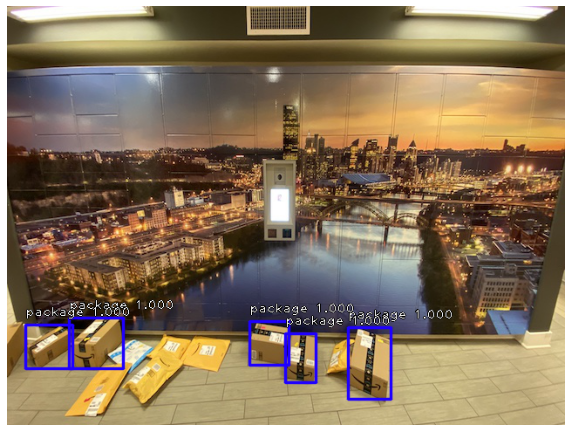

In [ ]:

uploaded = files.upload()
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)